# Compute Cl on galaxy overdensities on CosmoDC2

- author : Sylvie Dagoret-Campagne
- affliliation : IJCLab/in2p3/CNRS
- creation date : July 29th 2020


In [2]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import pyarrow

In [4]:
pyarrow.__version__

'0.15.1'

In [5]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [6]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [7]:
npix = hp.nside2npix(nside)
lmax = 3 * nside

In [8]:
def Ang2Pix_func(ra: pd.Series, dec: pd.Series) -> pd.Series:
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [9]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
#gal = gal.withColumn("ihealpix",pd_ang2pix(gal["RA"],gal["DEC"]))

## Get parquet files


### scan all availables files

In [10]:
import os,re

In [11]:
the_input_dir="/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/truth/galtruth"

In [12]:
the_list_of_files=os.listdir(the_input_dir)

In [19]:
the_list_of_files[:5]

['truth_summary_hp9304.sqlite3',
 'truth_summary_hp10194.sqlite3',
 'truth_summary_hp9945.parquet',
 'truth_summary_hp9939.parquet',
 'truth_summary_hp9944.sqlite3']

### sort all files

In [20]:
the_sorted_list_of_files=sorted(the_list_of_files)

### filter the good parquet files

In [21]:
selected_files=[]
for filename in the_sorted_list_of_files:
    sel_filename=re.findall("^truth_summary_hp.*.parquet$",filename)
    if len(sel_filename) > 0:
        selected_files.append(sel_filename[0])

In [22]:
selected_files[:5]

['truth_summary_hp10066.parquet',
 'truth_summary_hp10067.parquet',
 'truth_summary_hp10068.parquet',
 'truth_summary_hp10069.parquet',
 'truth_summary_hp10070.parquet']

In [23]:
InputPath = [the_input_dir + "/{}".format(filename) for filename in selected_files]

### Read files with spark

In [24]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

# Read the data as DataFrame
#df = spark.read.format("parquet").load(datafile)

In [25]:
#InputPath = [base_dir + "/dc2_object_run2.2i_dr6b_tract2897.parquet",
#             base_dir + "/dc2_object_run2.2i_dr6b_tract2898.parquet"]

df = spark.read.parquet(*InputPath)

In [26]:
df = df.repartition(df.rdd.getNumPartitions())

### DC2 Object catalog Schema

In [27]:
# Check what we have in the file
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- host_galaxy: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- redshift: float (nullable = true)
 |-- is_variable: integer (nullable = true)
 |-- is_pointsource: integer (nullable = true)
 |-- flux_u: float (nullable = true)
 |-- flux_g: float (nullable = true)
 |-- flux_r: float (nullable = true)
 |-- flux_i: float (nullable = true)
 |-- flux_z: float (nullable = true)
 |-- flux_y: float (nullable = true)
 |-- flux_u_noMW: float (nullable = true)
 |-- flux_g_noMW: float (nullable = true)
 |-- flux_r_noMW: float (nullable = true)
 |-- flux_i_noMW: float (nullable = true)
 |-- flux_z_noMW: float (nullable = true)
 |-- flux_y_noMW: float (nullable = true)



In [29]:
df_gal=df.filter('is_pointsource == false')

In [30]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
df_gal_healpix = df_gal.withColumn("ihealpix",pd_ang2pix(df_gal["ra"],df_gal["dec"]))

In [31]:
df_gal_healpix.printSchema()

root
 |-- id: long (nullable = true)
 |-- host_galaxy: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- redshift: float (nullable = true)
 |-- is_variable: integer (nullable = true)
 |-- is_pointsource: integer (nullable = true)
 |-- flux_u: float (nullable = true)
 |-- flux_g: float (nullable = true)
 |-- flux_r: float (nullable = true)
 |-- flux_i: float (nullable = true)
 |-- flux_z: float (nullable = true)
 |-- flux_y: float (nullable = true)
 |-- flux_u_noMW: float (nullable = true)
 |-- flux_g_noMW: float (nullable = true)
 |-- flux_r_noMW: float (nullable = true)
 |-- flux_i_noMW: float (nullable = true)
 |-- flux_z_noMW: float (nullable = true)
 |-- flux_y_noMW: float (nullable = true)
 |-- ihealpix: integer (nullable = true)



In [32]:
df_gal_healpix_small=df_gal_healpix.select('ra','dec','ihealpix')

In [33]:
df_gal_healpix_small.describe().show()

+-------+------------------+-------------------+------------------+
|summary|                ra|                dec|          ihealpix|
+-------+------------------+-------------------+------------------+
|  count|         943828477|          943828477|         943828477|
|   mean|61.806423064022624|-35.198415981597776| 2474036.867791798|
| stddev| 7.668031675203601|  5.873232421766818|131049.71135771515|
|    min| 47.73195595578662| -46.60694933341967|           2225472|
|    max| 75.97287254648704| -24.59513201507679|           2716447|
+-------+------------------+-------------------+------------------+



In [34]:
m=df_gal_healpix_small.groupBy('ihealpix').count()
m.show(5)

+--------+-----+
|ihealpix|count|
+--------+-----+
| 2587928|29491|
| 2596134|29005|
| 2585905|28652|
| 2594125|29454|
| 2577756|28733|
+--------+-----+
only showing top 5 rows



In [ ]:
#m.orderBy('ihealpix', ascending=True).show(10)

In [40]:
# get to python world (to Pandas) : 
# note that here is the action (lazy evaluation so far)
p=m.toPandas()
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34488 entries, 0 to 34487
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ihealpix  34488 non-null  int32
 1   count     34488 non-null  int64
dtypes: int32(1), int64(1)
memory usage: 404.3 KB


In [36]:
p

,ihealpix,count
0,2587928,29491
1,2596134,29005
2,2585905,28652
3,2594125,29454
4,2577756,28733
...,...,...
34483,2538918,27429
34484,2701391,3
34485,2489776,7
34486,2270484,3


/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-pyarrow/envs/desc/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


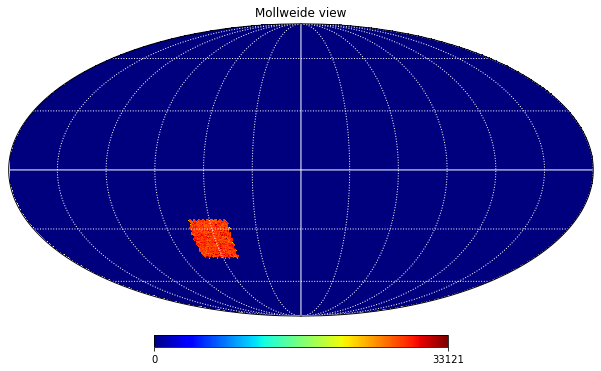

In [41]:
# the following doesn't has anything to do with spark (only Healpix)
hpMap = np.zeros(hp.nside2npix(nside))
#fill the map from the pandas object
hpMap[p['ihealpix'].values]=p['count'].values
#plot using standard healpy function
hp.mollview(hpMap,cmap="jet")
hp.graticule(color='white')

In [42]:
cl = hp.anafast(hpMap)
ell = np.arange(len(cl))

Text(0.5, 1.0, 'CosmoDC2 : $C_\\ell$ by healpix/anafast')

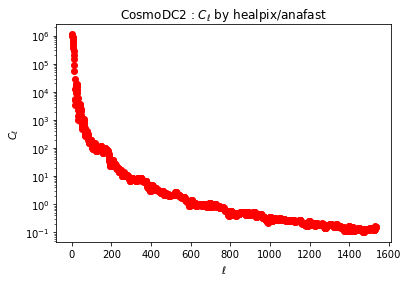

In [44]:
plt.plot(ell,cl,"ro")
plt.yscale('log')
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.title("{} : $C_\ell$ by healpix/anafast".format("CosmoDC2"))

In [45]:
lmax

1536

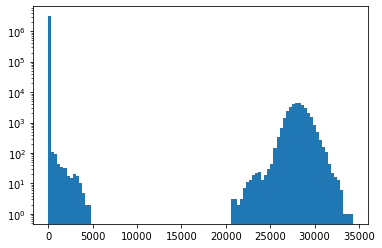

In [47]:
plt.hist(hpMap,bins=int(100))
plt.yscale('log')
plt.show()

In [48]:
hpMap.shape

(3145728,)